In [18]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_rel, wilcoxon

### Segmentation performance

In [9]:
paths_to_performance = {
    "proposed": "resources/segmentation/proposed/validation_performance.csv",
    "unet": "resources/segmentation/unet/2024_12_14_12_38_29_unet/validation_performance.csv",
    "unetr": "resources/segmentation/unetr/2024_12_14_13_09_39_unetr/validation_performance.csv",
    "swinunetr": "resources/segmentation/swinunetr/2024_12_14_13_55_51_swinunetr/validation_performance.csv"
}
final_epochs = {
    "proposed": 66,
    "unet": 25,
    "unetr": 15,
    "swinunetr": 15
}

In [3]:
df_all = pd.DataFrame()
for model, path in paths_to_performance.items():
    if model == "proposed":
        df = pd.read_csv(path)
        df.drop(
            columns = [
                'loss',
                'pixel_accuracy',
                'jaccard'
            ],
            inplace=True
        )
        df.rename(
            columns = {
                "image_filename": "image",
                "mask_filename": "mask"
            },
            inplace=True
        )
    else:
        df = pd.read_csv(path)
        df.drop(
            columns=[
                'seconds_per_patch'
            ],
            inplace=True
        )
    df["model"] = model
    df = df[df["epoch"] == final_epochs[model]].copy()
    df_all = pd.concat([df_all, df])
display(df_all)

,epoch,image,mask,dice,model
12480,66,image_9.tif,mask_9.tif,0.890126,proposed
12481,66,image_32.tif,mask_32.tif,0.901590,proposed
12482,66,image_55.tif,mask_55.tif,0.896965,proposed
12483,66,image_57.tif,mask_57.tif,0.948181,proposed
12484,66,image_58.tif,mask_58.tif,0.868978,proposed
...,...,...,...,...,...
571,15,image_1873.tif,mask_1873.tif,0.669496,swinunetr
572,15,image_1875.tif,mask_1875.tif,0.866235,swinunetr
573,15,image_1883.tif,mask_1883.tif,0.904412,swinunetr
574,15,image_1887.tif,mask_1887.tif,0.851401,swinunetr


In [15]:
# Mean performance (dice)
grouped = df_all.groupby('model')['dice'].describe()
display(grouped)

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
proposed,192.0,0.885343,0.042104,0.641700,0.871640,0.893372,0.913077,0.948181
swinunetr,192.0,0.885335,0.040126,0.610586,0.869754,0.893672,0.909616,0.945547
unet,192.0,0.874463,0.038913,0.651260,0.857490,0.882994,0.897941,0.938038
unetr,192.0,0.883358,0.042338,0.611164,0.866358,0.892832,0.911346,0.942995


In [20]:
df_all['model'].unique()

array(['proposed', 'unet', 'unetr', 'swinunetr'], dtype=object)

Testing normality proposed model ... p-value = 6.395433280256905e-14
Testing normality unet model ... p-value = 1.3765660929170911e-14
Testing normality unetr model ... p-value = 4.584688759680218e-15
Testing normality swinunetr model ... p-value = 1.0589322067273064e-15


/home/robber/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/robber/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/robber/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/robber/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Fut

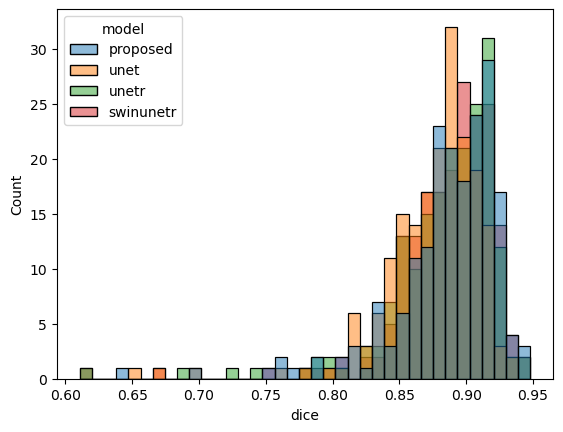

In [27]:
# Testing normality (p_value < 0.05 --> data is not drawn from a normal distribution)
for model in df_all['model'].unique().tolist():
    stat, p_value = shapiro(df_all[df_all['model'] == model]['dice'])
    print(f"Testing normality {model} model ... p-value = {p_value}")
sns.histplot(
    df_all,
    x='dice',
    hue='model'
)
plt.show()

In [31]:
# Testing statistical significance
for model in ("unet", "unetr", "swinunetr"):
    stat, p_value = wilcoxon(
        df_all[df_all['model'] == 'proposed']['dice'],
        df_all[df_all['model'] == model]['dice']
    )
    print(f"Testing statistical significance of performance ('proposed' versus '{model}') ... p-value = {p_value}")

Testing statistical significance of performance ('proposed' versus 'unet') ... p-value = 6.504359386182751e-10
Testing statistical significance of performance ('proposed' versus 'unetr') ... p-value = 0.131776092848955
Testing statistical significance of performance ('proposed' versus 'swinunetr') ... p-value = 0.9081006572118516


### Training execution times

In [12]:
paths_to_losses = {
    "unet": "resources/segmentation/unet/2024_12_14_12_38_29_unet/training_losses.csv",
    "unetr": "resources/segmentation/unetr/2024_12_14_13_09_39_unetr/training_losses.csv",
    "swinunetr": "resources/segmentation/swinunetr/2024_12_14_13_55_51_swinunetr/training_losses.csv"
}

In [13]:
df_training_times = pd.DataFrame()
for model, path in paths_to_losses.items():
    df = pd.read_csv(path)
    df['model'] = model
    df_training_times = pd.concat([df_training_times, df])
display(df_training_times)

,epoch,mean_loss,elapsed_time_seconds,model
0,1,0.553133,10.680214,unet
1,2,0.394253,10.659799,unet
2,3,0.225169,10.588295,unet
3,4,0.130598,10.025197,unet
4,5,0.097380,10.369621,unet
...,...,...,...,...
95,96,0.014495,35.839685,swinunetr
96,97,0.014421,35.675516,swinunetr
97,98,0.014113,36.059636,swinunetr
98,99,0.014114,35.732321,swinunetr


In [14]:
grouped = df_training_times.groupby('model')['elapsed_time_seconds'].describe()
display(grouped)

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
swinunetr,100.0,35.863475,0.259517,35.362839,35.694935,35.852596,35.995553,36.820189
unet,100.0,10.504107,0.213147,9.798356,10.364758,10.515948,10.662456,10.969299
unetr,100.0,25.374651,0.240180,24.750391,25.229354,25.374104,25.532233,26.088308


### Inference execution times

In [6]:
df_inference_times = pd.DataFrame()
for model, path in paths_to_performance.items():
    if model == "proposed":
        continue
    df = pd.read_csv(path)
    df['model'] = model
    df = df[df['epoch'] == final_epochs[model]]
    df_inference_times = pd.concat([df_inference_times, df])
display(df_inference_times)

,epoch,image,mask,dice,seconds_per_patch,model
768,25,image_9.tif,mask_9.tif,0.892871,0.006168,unet
769,25,image_32.tif,mask_32.tif,0.884567,0.006168,unet
770,25,image_55.tif,mask_55.tif,0.865043,0.006168,unet
771,25,image_57.tif,mask_57.tif,0.919674,0.006168,unet
772,25,image_58.tif,mask_58.tif,0.879374,0.006168,unet
...,...,...,...,...,...,...
571,15,image_1873.tif,mask_1873.tif,0.669496,0.023481,swinunetr
572,15,image_1875.tif,mask_1875.tif,0.866235,0.023481,swinunetr
573,15,image_1883.tif,mask_1883.tif,0.904412,0.023481,swinunetr
574,15,image_1887.tif,mask_1887.tif,0.851401,0.023481,swinunetr


In [8]:
grouped = df_inference_times.groupby('model')['seconds_per_patch'].describe()
display(grouped)

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
swinunetr,192.0,0.023481,3.130666e-17,0.023481,0.023481,0.023481,0.023481,0.023481
unet,192.0,0.006168,1.217481e-17,0.006168,0.006168,0.006168,0.006168,0.006168
unetr,192.0,0.019900,1.739259e-17,0.019900,0.019900,0.019900,0.019900,0.019900
